<a href="https://colab.research.google.com/github/wuchenyu38/18ma573chenyuwu/blob/master/src/Fourier_Transform_Heston_BSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BSM Model



In [26]:
!git clone https://github.com/cantaro86/Financial-Models-Numerical-Methods.git

Cloning into 'Financial-Models-Numerical-Methods'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 325 (delta 189), reused 242 (delta 109), pack-reused 0
Receiving objects: 100% (325/325), 10.81 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [27]:
import scipy.integrate as int
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial

In [56]:
s0=100; r= .0475; sigma=  .2; otype = 1; K = 110; T = 1;

In [29]:
#Calculate I_1
d1=(np.log(s0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
I1=(1/2)+(1/np.pi)*int.quad(lambda t: (np.sin(d1*t)/t)*np.exp((-1)*t**2/2),0,np.inf)[0]

In [30]:
#Calculate I_2
d2=(np.log(s0/K)+(r-(sigma**2)/2)*T)/(sigma*np.sqrt(T))
I2=(1/2)+(1/np.pi)*int.quad(lambda t: (np.sin(d2*t)/t)*np.exp((-1)*t**2/2),0,np.inf)[0]

In [31]:
#Get Price
C=(s0*I1)-K*np.exp(-r*T)*I2
print('Price =', C)

Price = 5.943273183452845


$$
C_T(k) = \frac{exp(-\alpha k)}{\pi}\sum^{N}_{j=1}e^{-iv_jk}\psi_T(v_j)\eta
$$

$$
C_T(k_u) = \frac{exp(-\alpha k)}{\pi}\sum^{N}_{j=1}e^{-i\lambda\eta(j-1)(u-1)}e^{ibv_j}\psi_T(v_j)\eta
$$

k = ln(K) </br>
$
\lambda\eta = \frac{2\pi}{N}
$</br>
$b = \frac{1}{2}N\lambda$</br>


In [87]:
def BSM_characteristic_function(v, x0, T, r, sigma):
    cf_value = np.exp(((x0 / T + r - 0.5 * sigma ** 2) * 1j * v
                - 0.5 * sigma ** 2 * v ** 2) * T)
    return cf_value
def BSM_call_characteristic_function(v,alpha, x0, T, r, sigma):
    res=np.exp(-r*T)/((alpha+1j*v)*(alpha+1j*v+1))\
        *BSM_characteristic_function((v-(alpha+1)*1j), x0, T, r, sigma)
    return res
    
def SimpsonW(N,eta):
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = eta*(3 + (-1) ** j - delt) / 3
    return SimpsonW

In [92]:
def BSM_call_value_FFT(S0, K, T, r, sigma):
    k = np.log(K)
    x0 = np.log(S0)
    N =2**10
    alpha=1.5
    
    eta=0.15
    lambda_ = 2 * np.pi / (N *eta)
    beta=x0-lambda_*N/2
    km=np.asarray([beta+i*lambda_ for i in range(N)])
    W=SimpsonW(N,eta)
    v=np.asarray([i*eta for i in range(N)])
    Psi=np.asarray([BSM_call_characteristic_function(vj,alpha, x0, T, r, sigma)  for vj in v])
    FFTFunc=Psi*np.exp(-1j*beta*v)*eta
    y=np.fft.fft(FFTFunc).real
    cT=np.exp(-alpha*km)*y/np.pi
    
    return np.exp(km),cT

In [93]:
k,c=BSM_call_value_FFT(S0, K, T, r, sigma)
print(np.interp(K, k, c))

6.618725304181327


Heston Model

In [32]:
import os

In [33]:
cd Financial-Models-Numerical-Methods

/content/Financial-Models-Numerical-Methods/Financial-Models-Numerical-Methods


In [34]:
from functions.probabilities import Heston_pdf, Q1, Q2
from functions.cython.cython_Heston import Heston_paths_log, Heston_paths

In [35]:
r = 0                                           # drift
rho = -0.5751                                   # correlation coefficient
kappa = 1.5768                                  # mean reversion coefficient
theta = 0.0398                                  # long-term mean of the variance
sigma = 0.5751                                  # (Vol of Vol) - Volatility of instantaneous variance
T = 10                                          # Terminal time
K = 80                                          # Stike  
v0 = 0.0175                                     # spot variance
S0 = 100                                        # spot stock price 
k = np.log(K/S0)                                # log moneyness

In [36]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi+d)*t - 2*np.log( (1-g1*np.exp(d*t))/(1-g1) ))\
              + (v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) )
    return cf

In [37]:
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    g2 = 1/g1
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
              + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
    return cf

In [38]:
cf_H_b = partial(cf_Heston, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho) 
cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho )

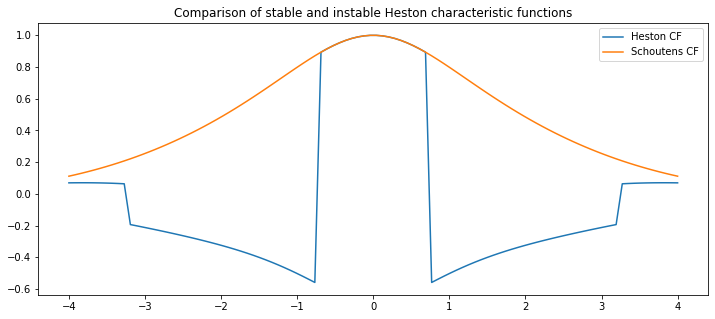

In [39]:
u = np.linspace(-4,4, 100)

plt.figure(figsize=(12,5))
plt.plot(u, np.real(cf_H_b(u)), label="Heston CF" )
plt.plot(u, np.real(cf_H_b_good(u)), label="Schoutens CF" )
plt.title("Comparison of stable and instable Heston characteristic functions")
plt.legend(); plt.show()

In [40]:
%%time
limit_max = 1000      # right limit in the integration                
call = S0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r*T) * Q2(k, cf_H_b_good, limit_max)
print("Heston Fourier inversion call price: ", call)
print("-----------------------------------")

Heston Fourier inversion call price:  32.579577859908646
-----------------------------------
CPU times: user 29.7 ms, sys: 41 µs, total: 29.8 ms
Wall time: 31.7 ms
